In [35]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import seaborn as sns
from matplotlib import pyplot as plt

## Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records"
Download the data for January and February 2021
Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".
Read the data for January. How many records are there?

**1154112**

In [48]:
train_df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')
val_df = pd.read_parquet('../data/fhv_tripdata_2021-02.parquet')

In [49]:
train_df.shape, val_df.shape

((1154112, 7), (1037692, 7))

In [50]:
train_df.head()

dispatching_base_num     pickup_datetime    dropOff_datetime  PUlocationID  \
0               B00009 2021-01-01 00:27:00 2021-01-01 00:44:00           NaN   
1               B00009 2021-01-01 00:50:00 2021-01-01 01:07:00           NaN   
2               B00013 2021-01-01 00:01:00 2021-01-01 01:51:00           NaN   
3               B00037 2021-01-01 00:13:09 2021-01-01 00:21:26           NaN   
4               B00037 2021-01-01 00:38:31 2021-01-01 00:53:44           NaN   

   DOlocationID SR_Flag Affiliated_base_number  
0           NaN    None                 B00009  
1           NaN    None                 B00009  
2           NaN    None                 B00013  
3          72.0    None                 B00037  
4          61.0    None                 B00037

In [51]:
val_df.head()

dispatching_base_num     pickup_datetime    dropOff_datetime  PUlocationID  \
0               B00013 2021-02-01 00:01:00 2021-02-01 01:33:00           NaN   
1      B00021          2021-02-01 00:55:40 2021-02-01 01:06:20         173.0   
2      B00021          2021-02-01 00:14:03 2021-02-01 00:28:37         173.0   
3      B00021          2021-02-01 00:27:48 2021-02-01 00:35:45          82.0   
4               B00037 2021-02-01 00:12:50 2021-02-01 00:26:38           NaN   

   DOlocationID SR_Flag Affiliated_base_number  
0           NaN    None                 B00014  
1          82.0    None        B00021           
2          56.0    None        B00021           
3         129.0    None        B00021           
4         225.0    None                 B00037

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

**19.16**

In [55]:
def add_features(df):
    df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
    df['duration'] = df['duration'] / np.timedelta64(1, 's') / 60
    return df

In [53]:
train_df = add_features(train_df)
val_df = add_features(val_df)

In [54]:
train_df['duration'].mean(), val_df['duration'].mean()

(19.1672240937939, 20.70698622520125)

## Data preparation
Check the distribution of the duration variable. There are some outliners.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

<AxesSubplot:>

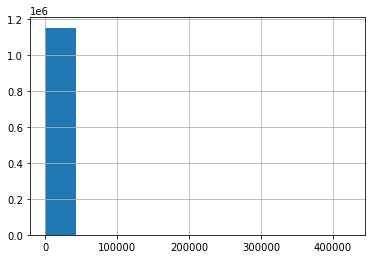

In [56]:
train_df['duration'].hist()

In [57]:
train_df['duration'].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [58]:
full_len = train_df.shape[0]

In [59]:
def clean_data(df):
    df = df[df['duration'].between(1, 60)]
    return df

In [60]:
train_df = clean_data(train_df)
val_df = clean_data(val_df)

In [64]:
train_df['duration'].hist()

<AxesSubplot:>

In [61]:
train_df.shape, val_df.shape

((1109826, 8), (990113, 8))

In [63]:
print('Dropped outliers:', full_len - train_df.shape[0])

Dropped outliers: 44286


## Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1"

What's the factions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

**83%**

In [25]:
train_df.isna().sum() / train_df.shape[0]

dispatching_base_num      0.000000
pickup_datetime           0.000000
dropOff_datetime          0.000000
PUlocationID              0.835273
DOlocationID              0.133270
SR_Flag                   1.000000
Affiliated_base_number    0.000697
duration                  0.000000
dtype: float64

In [65]:
train_df.fillna(-1, inplace=True)
val_df.fillna(-1, inplace=True)

## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix? (The number of columns)

**525**

In [66]:
cat_columns = ['PUlocationID', 'DOlocationID']

train_df[cat_columns] = train_df[cat_columns].astype(str)
val_df[cat_columns] = val_df[cat_columns].astype(str)

In [67]:
train_dicts = train_df[cat_columns].to_dict(orient='records')
val_dicts = val_df[cat_columns].to_dict(orient='records')

dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

target = 'duration'

y_train = train_df[target].values
y_val = val_df[target].values

In [68]:
X_train.shape, X_val.shape

((1109826, 525), (990113, 525))

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

**10.52**

In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [70]:
y_train_pred = lr.predict(X_train)
mean_squared_error(y_train, y_train_pred, squared=False)

10.5285191072072

## Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation

**11.01** (closest answer is 12.85)

In [71]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.014283163400654